### Configuração Inicial

In [1]:
import pathlib
import sys
if str(pathlib.Path().resolve().name) == "TP1":
    root = str(pathlib.Path().resolve().parent)+'/'
    sys.path.append(root)
    requirements_path = root + 'TP1/requirements.txt'
else:
    ! git clone https://github.com/Fabio-Trindade/Eng-Aprendizado-Maquina.git
    root = str(pathlib.Path().resolve())
    src_path = root + '/Eng-Aprendizado-Maquina/'
    requirements_path = src_path + 'TP1/requirements.txt'
    sys.path.append(root + '/Eng-Aprendizado-Maquina/')

! pip install -r $requirements_path

### Imports

In [2]:
import pandas as pd
from src.datasets.spaceship_titanic_dataset import SpaceshipTitanicDataset
from src.models.spaceship_model import SpaceShipModel
from src.pre_processors.pre_processor_spaceship import PreProcessorSpaceship
from src.transforms.to_torch_tensor import NumpyToTorchTensor
from src.utils.util_path import UtilPath
import torch
from torch import nn
from torch.utils.data import DataLoader
import numpy as np

### Os dados
Os dados são constituídos das seguintes informações (retiradas em [kaggle](https://www.kaggle.com/competitions/spaceship-titanic/data)):
* PassengerId - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
* HomePlanet - The planet the passenger departed from, typically their planet of permanent residence.
* CryoSleep - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
* Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
* Destination - The planet the passenger will be debarking to.
* Age - The age of the passenger.
* VIP - Whether the passenger has paid for special VIP service during the voyage.
* RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
* Name - The first and last names of the passenger.
* Transported - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

In [3]:
root_path = UtilPath.get_root_path()

df = pd.read_csv(root_path+'/datasets/spaceship-titanic/train.csv')
df

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True
8691,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False


## Inicializando os transformadores
* NumpyToTorchTensor: Transforma um array numpy em um tensor torch. 

### Classe do transformador
```python
class NumpyToTorchTensor:
    def __init__(self, dtype):
        self.dtype = dtype
    def __call__(self, sample ):
        return torch.tensor(sample.tolist(),dtype=self.dtype)
```

In [4]:
transform_float = NumpyToTorchTensor(dtype=float)
transform_int = NumpyToTorchTensor(dtype=int)

## Pré-Processamento

* Os dados das colunas PassengerId, HomePlanet, CryoSleep, Cabin, VIP, Name e Transported foram tratados como dados categóricos, enquanto as colunas restantes foram tratadas como dados númericos. A etapa de pré-processamento deste trabalho consiste da criação de vocabulários a partir das palavras de cada dado categórico, os quais posteriormente passarão por uma rede de __embedding__ para serem representados em um espaço de __d__ dimensões. Além disso, os dados das colunas Passenger_Id, Cabin e Name foram separados (__splitted__), respectivamente, pelos caracteres "_", "/" e " ", gerando mais informações. Por exemplo, se um passageiro é representado pelo Id "0001_01", o novo dado gerado será ["0001","01"]. Já o vocábulário é representado por um dicionário que mapeia um texto em um valor numérico.

* Vale ressaltar que, como são gerados vocabulários a partir dos textos dos dados categóricos, é necessário estabelecer um vocábulo para representar os textos nunca vistos, ou seja, aqueles que não estão nos dados de treinamento, sendo este o vocábulo 'unknown'.

O* utro ponto importante sobre o pré-processamento: os dados das colunas CryoSleep e VIP (com valor booleano) foram concatenados com o valor do vocábulo do nome da sua coluna. Por ex., se para uma __feature__ existe um valor False em CryoSleep (com representação no vocabulário com valor 7) e um valor True (com representação no vocabulário com valor 8) e o texto 'CryoSleep' e 'VIP' são representados, respectivamente, pelos valores 534 e 533, o novo dado gerado na coluna CryoSleep e VIP serão, respectivamente, [7,534] e [8,533].

A classe abaixo contém o código utilizado para realizar o pré-processamento dos dados, tanto para o treinamento, quanto para o teste. Ao final do pré-processamento dos dados de treino, é retornada uma lista com todos os dados pré-processados, ou seja, os dados categóricos representados pelos respectivos valores gerados no vocabulário criado e já descompactados das suas formas de listas, mais os dados numéricos. O pré-processamento dos dados de teste ocorrem da mesma forma, com exceção de que, ao invés de criar um vocabulário, é utilizado o vocabulário já criado no pré-processamento dos dados de treinamento para transformar os dados categóricos.

```python

class PreProcessorSpaceship:
    def __init__(self, csv_train_filename: str):
        self.df = pd.read_csv(csv_train_filename)
        self.pre_processed_df = None
        self.vocab = None
    
    def get_columns_name(self):
        return self.df.columns

    def get_words_by_column(sel,df,column_name):
        words = set()
        for words_list in df[column_name]:
            for word in words_list:
                words.add(word)
        return list(words)


    def pre_process(self):
        if self.pre_processed_df != None:
            return self.pre_processed_df, self.vocab

        pre_processed_df = self.df.copy() 

        dict_max_len = {}

        other_columns_to_be_processed = ['PassengerId','Cabin','Name']
        columns_to_be_processed = ['HomePlanet','Destination']
        boolean_columns = ["CryoSleep", "VIP"]
        remain_columns =["Age","RoomService","FoodCourt","ShoppingMall","Spa","VRDeck"]
        
        for column in remain_columns:
            pre_processed_df[column] = pre_processed_df[column].fillna(-1) 
        
        for column in boolean_columns + other_columns_to_be_processed + columns_to_be_processed + ["Transported"]:
            pre_processed_df[column] = pre_processed_df[column].astype(str)

        for column in remain_columns:
            pre_processed_df[column] = pre_processed_df[column].astype(float)
        
        pre_processed_df["PassengerId"] = UtilPreProcessor.split_column_data_by_pattern(pre_processed_df,"PassengerId","_")
        pre_processed_df["Cabin"] = UtilPreProcessor.split_column_data_by_pattern(pre_processed_df,"Cabin","/")
        pre_processed_df["Name"] = UtilPreProcessor.split_column_data_by_pattern(pre_processed_df,"Name"," ")        

        passenger_id_words = self.get_words_by_column(pre_processed_df,"PassengerId")
        cabin_words = self.get_words_by_column(pre_processed_df,"Cabin")
        name_words = self.get_words_by_column(pre_processed_df,"Name")
        words = UtilPreProcessor.get_unique_values_by_columns(pre_processed_df,columns_to_be_processed + boolean_columns) + columns_to_be_processed  \
                                                    + boolean_columns + passenger_id_words + cabin_words + name_words + \
        [f"{i}{j}{k}{l}" for i in range(10) for j in range(10) for k in range(10) for l in range(10)] + [str(i) for i in range(10**4)] + ['unknown']
        vocab_to_index, index_to_vocab = UtilPreProcessor.creat_vocab(words)
        
        for column in other_columns_to_be_processed:
            listt = pre_processed_df[column].to_list()
            max_len = max(len(sublist) for sublist in listt)
            dict_max_len[column] = max_len

        for column in other_columns_to_be_processed:
            pre_processed_df[column] = pre_processed_df[column].apply(lambda x: [vocab_to_index[vocab] for vocab in x] if len(x) == dict_max_len[column] else [vocab_to_index['nan'] for _ in range(dict_max_len[column])])

        for column in columns_to_be_processed:
            pre_processed_df[column] = pre_processed_df[column].apply(lambda x: vocab_to_index[x])

        for column in boolean_columns:
            pre_processed_df[column] = pre_processed_df[column].apply(lambda x: [vocab_to_index[x],vocab_to_index[column]])

        pre_processed_df['Transported'] = pre_processed_df['Transported'].apply(lambda x: vocab_to_index[x])
        pre_processed_data = []
        
        for i,row in enumerate(pre_processed_df.itertuples(index=False)):
            pre_processed_data.append([])
            for data in (row):
                if data.__class__ is list:
                    pre_processed_data[i] += data
                else:
                    pre_processed_data[i].append(data)

        self.vocab = [vocab_to_index,index_to_vocab]
        self.pre_processed_df = pre_processed_df
        return pre_processed_data, self.vocab
    
    def pre_process_test(self,csv_filename):
        df_test = pd.read_csv(csv_filename)

        pre_processed_df = df_test.copy() 

        dict_max_len = {}

        other_columns_to_be_processed = ['PassengerId','Cabin','Name']
        columns_to_be_processed = ['HomePlanet','Destination']
        boolean_columns = ["CryoSleep", "VIP"]
        remain_columns =["Age","RoomService","FoodCourt","ShoppingMall","Spa","VRDeck"]
        
        for column in remain_columns:
            pre_processed_df[column] = pre_processed_df[column].fillna(-1) 
        
        for column in boolean_columns + other_columns_to_be_processed + columns_to_be_processed:
            pre_processed_df[column] = pre_processed_df[column].astype(str)

        for column in remain_columns:
            pre_processed_df[column] = pre_processed_df[column].astype(float)
        
        pre_processed_df["PassengerId"] = UtilPreProcessor.split_column_data_by_pattern(pre_processed_df,"PassengerId","_")
        pre_processed_df["Cabin"] = UtilPreProcessor.split_column_data_by_pattern(pre_processed_df,"Cabin","/")
        pre_processed_df["Name"] = UtilPreProcessor.split_column_data_by_pattern(pre_processed_df,"Name"," ")        

        
        for column in other_columns_to_be_processed:
            listt = pre_processed_df[column].to_list()
            max_len = max(len(sublist) for sublist in listt)
            dict_max_len[column] = max_len

        for column in other_columns_to_be_processed:
            pre_processed_df[column] = pre_processed_df[column].apply(lambda x: [self.vocab[0][vocab] if self.vocab[0].get(vocab) != None else self.vocab[0]['unknown']  for vocab in x] if len(x) == dict_max_len[column] else [self.vocab[0]['nan'] for _ in range(dict_max_len[column])])

        for column in columns_to_be_processed:
            pre_processed_df[column] = pre_processed_df[column].apply(lambda x:self.vocab[0][x] if self.vocab[0].get(x) != None else self.vocab[0]['unknown'] )

        for column in boolean_columns:
            pre_processed_df[column] = pre_processed_df[column].apply(lambda x: [self.vocab[0][x] if self.vocab[0].get(x) != None else self.vocab[0]['unknown'] ,self.vocab[0][column]])

        pre_processed_data = []
        
        for i,row in enumerate(pre_processed_df.itertuples(index=False)):
            pre_processed_data.append([])
            for data in (row):
                if data.__class__ is list:
                    pre_processed_data[i] += data
                else:
                    pre_processed_data[i].append(data)

        return pre_processed_data
```

### Pré-processando os dados de treinamento

In [5]:
pre_processor = PreProcessorSpaceship(root_path+"/datasets/spaceship-titanic/train.csv")
pre_processed_data, vocab = pre_processor.pre_process()

In [6]:
print("Feature original:")
display(pre_processor.df.head(1))
print('Feature pré-processada:')
print(pre_processed_data[0])

Feature original:


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False


Feature pré-processada:
[1590, 6071, 0, 7, 11, 7460, 6361, 7278, 4, 39.0, 7, 12, 0.0, 0.0, 0.0, 0.0, 0.0, 9716, 8160, 7]


### Pré-processamento dos dados de teste

In [7]:
pre_processed_test_data = pre_processor.pre_process_test(root_path+"/datasets/spaceship-titanic/test.csv")

## Criação das classes dataset

Para facilitar a manipulação dos dados do dataset foi criada a classe abaixo:

```python
class SpaceshipTitanicDataset(Dataset):
    def __init__(self, data, transform = None,type ='train'):
        if type == 'train':
            self.y = np.array(data,dtype=float)[:,-1]
            self.x = np.array(data,dtype=float)[:,:-1]
        else:
            self.x = np.array(data,dtype=float)
            self.y = np.array(data,dtype=float)[:,-1]
        self.transform = transform
        self.len = len(self.x)

    def __getitem__(self,index):
        if self.transform:
            return self.transform(self.x[index]),self.transform(self.y[index])
        return self.x[index],self.y[index]

    def __len__(self):
        return self.len

```

### Criação dos datasets de treino e teste

In [8]:
train_dataset = SpaceshipTitanicDataset(pre_processed_data,transform=transform_float)
test_dataset = SpaceshipTitanicDataset(pre_processed_test_data,transform=transform_float,type='eval')

## O modelo

O modelo consiste de uma rede neural com uma camada de Embedding para criar representações para os dados categóricos transformados a partir do vocabulário criado na etapa de pré-processamento e uma camada Linear para transformar todas as features geradas em uma representação de __d__ dimensões. Apesar de ser um problema de classificação, o modelo é treinado para gerar uma representação que seja próxima das representações de "True" ou "False" de acordo com os labels fornecidos. Dessa forma, se a predição está mais próxima da representação de "True", então a resposta do modelo é mapeado para True, caso contrário, False. Além disso, o modelo conta com uma camada de dropout e uma função não linear LeakyReLU, como visto na classe abaixo.

Os parâmetros do modelo são:
* dim_total_data: Quantidade de features cada passageiro após a etapa de pré-processamento;
* dim_total_vocab_data: Quantidade de features de cada passageiro que passarão pela rede de embedding;
* len_vocab: Quantidade de palavras no vocabulário criado na etapa de pré-processamento;
* dim_embedd: Dimensão das representações geradas pela rede de Embeding;
* dropout: Taxa de dropout aplicada na rede.

```python
class SpaceShipModel(nn.Module):
    def __init__(self,dim_total_data,dim_total_vocab_data,len_vocab,dim_embedd,dropout = 0.5):
        super(SpaceShipModel,self).__init__()
        self.embedding = nn.Embedding(len_vocab,dim_embedd,dtype=float)
        self.linear = nn.Linear((dim_total_data-dim_total_vocab_data) + dim_total_vocab_data*dim_embedd,dim_embedd,dtype=float)
        self.dim_total_vocab_data = dim_total_vocab_data
        self.dim_embedd = dim_embedd
        self.leaky_relu = nn.LeakyReLU(0.2)
        self.dropout = nn.Dropout(dropout)

    
    def forward(self, features_embedding, remain_features,batch_size):
        x = self.embedding(features_embedding)
        x = x.reshape((batch_size,self.dim_total_vocab_data*self.dim_embedd))
        x = self.dropout(x)
        return  self.leaky_relu(self.linear(torch.concat([x,remain_features],dim=1)))


```

In [9]:
# Estrutura criada para automatizar cálculos necessários
# Contém o nome das colunas categóricas como chave
# Seus valores são, respectivamente, o índice inicial da coluna e a quantidade de dados que esta coluna contém
vocab_columns = {
    "PassengerId": [0,2],
    "HomePlanet": [1,1],
    "CryoSleep": [2,2],
    "Cabin": [3,3],
    "VIP": [6,2],
    "Name": [12,2]
}

### Definindo os hyperparâmetros

In [18]:
len_vocab = len(vocab[0])
dim_total_data = len(pre_processed_data[0]) - 1
sum_values = lambda x: sum(v[1] for v in x)
dim_total_vocab_data = sum_values(list(vocab_columns.values()))

dim_embedd = 32
batch_size = 32 
epochs = 15

### Criando o modelo

In [17]:
model = SpaceShipModel(dim_total_data,dim_total_vocab_data,len_vocab,dim_embedd)
optim = torch.optim.Adam(model.parameters(),0.001)
loss_fn = nn.MSELoss()

### Função auxiliar

A função abaixo separa as features em: 
1. Features que serão utilizadas na rede de embedding; 
2. Features que não serão utilizadas na rede de embedding.

In [12]:
def process_features(features,transform_int:NumpyToTorchTensor,transform_float:NumpyToTorchTensor):
    indexes = []
    shift = 0
    for k,v in vocab_columns.values():
        for i in range(k+shift,k+v+shift):
            indexes.append(i)
        shift += v-1
    features_embedding = []
    remain_features = []
    with torch.no_grad():
        for i,passenger_feature in enumerate(features):
            features_embedding.append([])
            remain_features.append([])
            for j,feature in enumerate(passenger_feature.tolist()):
                if j in indexes:
                    features_embedding[i].append(feature)
                else:
                    remain_features[i].append(feature)
    return transform_int(np.array(features_embedding)),transform_float(np.array(remain_features))

### Treinamento

In [19]:
dataloader = DataLoader(train_dataset,batch_size, shuffle=True, num_workers=2)

for epoch in range(epochs):
    for features,target in dataloader:
        embedding_features, remain_features = process_features(features, transform_int,transform_float)
        optim.zero_grad()
        predictions = model(embedding_features,remain_features,len(features))
        
        target = transform_int(target)
        embedd_target = model.embedding(target)
        
        loss = loss_fn(predictions, embedd_target)
        loss.backward()
        
        optim.step()

    print(f"epoch {epoch + 1} - loss {loss}")

torch.save(model.state_dict(), root_path+'/checkpoints/spaceship_titanic_model.pth')

epoch 1 - loss 2.319445948598375
epoch 2 - loss 1.2466407330224183
epoch 3 - loss 0.5719880165364672
epoch 4 - loss 0.3532477424361799
epoch 5 - loss 0.27080168387228876
epoch 6 - loss 0.29592741072697026
epoch 7 - loss 0.18540925708619216
epoch 8 - loss 0.45490670488106877
epoch 9 - loss 0.17859238968327804
epoch 10 - loss 0.16920813056240033
epoch 11 - loss 0.12235501305298284
epoch 12 - loss 0.38471150591795933
epoch 13 - loss 0.39892413260545173
epoch 14 - loss 0.668356029270231
epoch 15 - loss 0.05880894868435274


### Gerando resultados para submissão no Kaggle

In [20]:
model.eval()

df_sample_submission = pd.DataFrame({"PassengerId":[],"Transported":[]}) 

embedd_true = model.embedding(transform_int(np.array(vocab[0]['True'])))
embedd_true = embedd_true.reshape((1,dim_embedd))

embedd_false = model.embedding(transform_int(np.array(vocab[0]['False'])))
embedd_false = embedd_false.reshape((1,dim_embedd))
for i in range(len(test_dataset)):
    x,_= test_dataset[i]
    embedding_features, remain_features = process_features([x], transform_int,transform_float)
    prediction = model(embedding_features,remain_features,1)
    mse_true = loss_fn(prediction,embedd_true)
    mse_false = loss_fn(prediction,embedd_false)
    if mse_false < mse_true:
        pred = "False"
    else:
        pred = "True"
    string = f"{vocab[1][int(x[0].item())]}_{vocab[1][int(x[1].item())]}"
    dict_data = {
        "PassengerId":[string],
        "Transported": pred
    }
    temp_df  = pd.DataFrame(dict_data)
    df_sample_submission = pd.concat([temp_df,df_sample_submission],ignore_index =True)
df_sample_submission.to_csv(root_path+"/datasets/spaceship-titanic/sample_submission.csv",index=False)

### Resultados das submissões
__Nome de usuário do Kaggle: fabiotrindaderamos.__
Foram realizados variações nos hyperparâmetros com o objetivo de aumentar a precião do modelo. A imagem abaixo apresenta os resultados obtidos nas diferentes tentativas:
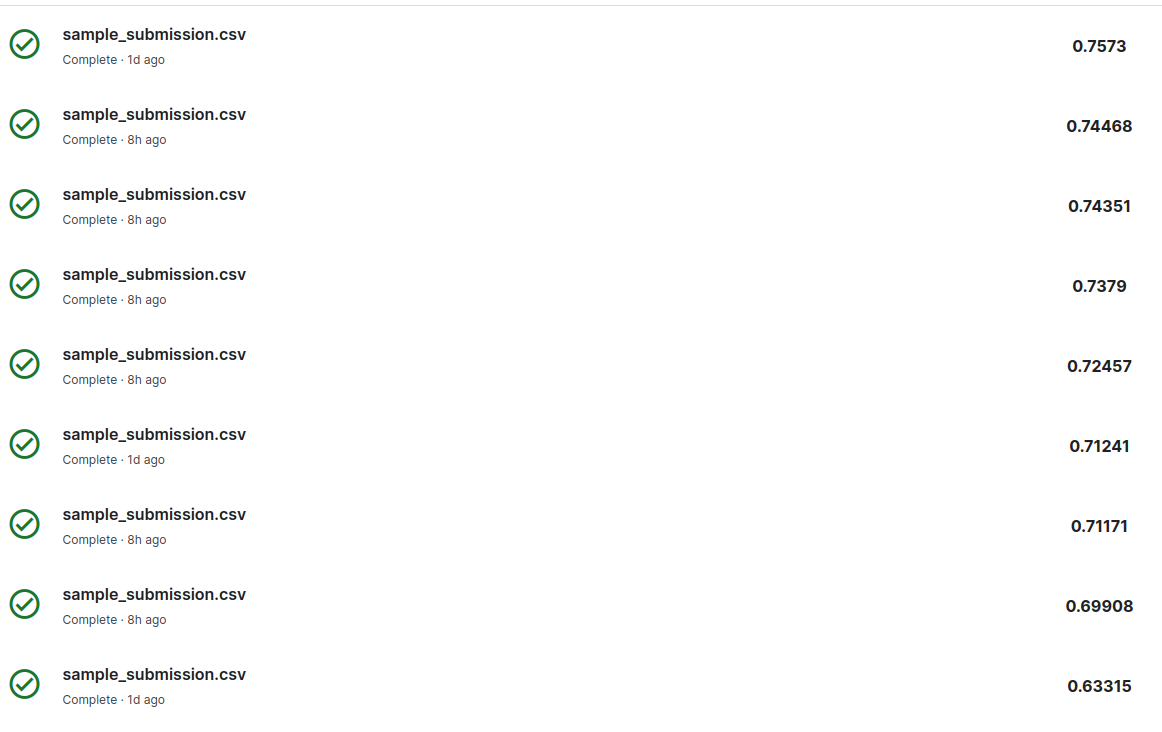